In [1]:
from google.colab import files
uploades = files.upload ()

Saving harga komoditass.xlsx to harga komoditass.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load data dari Excel
data = pd.read_excel('harga komoditass.xlsx')
data['Periode'] = pd.to_datetime(data['Periode'])
data.set_index('Periode', inplace=True)


IMPROVED RICE PRICE FORECASTING MODEL
Loading and preparing data...
Training size: 82 months
Test size: 21 months

Training improved model...
Preparing data...
Training SARIMA model...
Best SARIMA model AIC: 44.26
Training LSTM model...
LSTM training completed. Final loss: 0.045364

Performing backtesting...
EVALUASI IMPROVED PADI MODEL
MAE: 0.43
MSE: 0.33
RMSE: 0.58
MAPE: 6.83%
Directional Accuracy: 85.00%

Training final model on full dataset...
Preparing data...
Training SARIMA model...
Best SARIMA model AIC: 61.73
Training LSTM model...
LSTM training completed. Final loss: 0.024900

HASIL PREDIKSI FINAL:
              Periode  Padi_Prediksi
2025-08-01 2025-08-01           6.17
2025-09-01 2025-09-01           6.46
2025-10-01 2025-10-01           6.30
2025-11-01 2025-11-01           6.40
2025-12-01 2025-12-01           6.66
2026-01-01 2026-01-01           7.13
2026-02-01 2026-02-01           6.77
2026-03-01 2026-03-01           6.61
2026-04-01 2026-04-01           5.96
2026-05-01 202

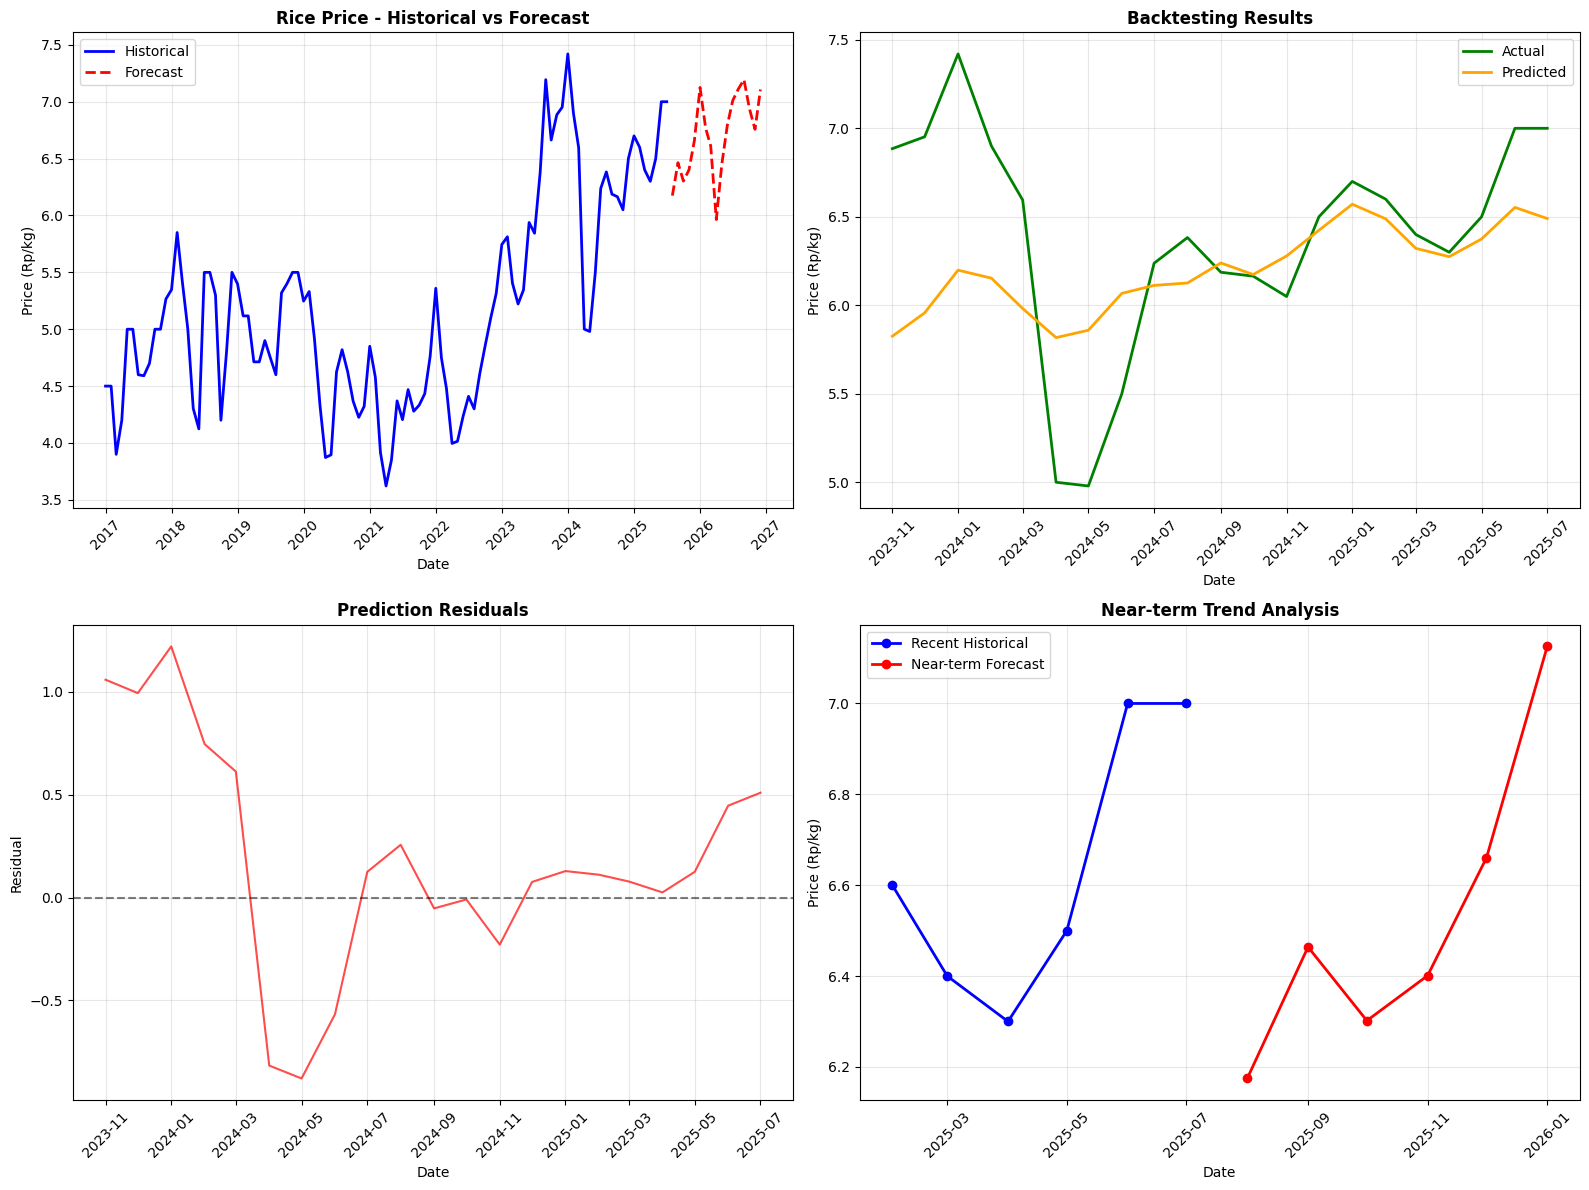


Predictions saved to 'hasil_prediksi_padi_improved.xlsx'

MODEL PERFORMANCE SUMMARY:
MAPE: 6.83% (Target: <10%)
MAE: 0.43
RMSE: 0.58
Directional Accuracy: 85.00% (Target: >70%)

FORECAST SUMMARY:
Current Price (Jul 2025): Rp 7.00
Average Forecast Price: Rp 6.70
Monthly Trend: +0.05 Rp/month
Price Range: Rp 5.96 - Rp 7.19


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Data input
data_dict = {
    'Periode': ['Jan-2017', 'Feb-2017', 'Mar-2017', 'Apr-2017', 'Mei-2017', 'Jun-2017',
                'Jul-2017', 'Agu-2017', 'Sep-2017', 'Okt-2017', 'Nov-2017', 'Des-2017',
                'Jan-2018', 'Feb-2018', 'Mar-2018', 'Apr-2018', 'Mei-2018', 'Jun-2018',
                'Jul-2018', 'Agu-2018', 'Sep-2018', 'Okt-2018', 'Nov-2018', 'Des-2018',
                'Jan-2019', 'Feb-2019', 'Mar-2019', 'Apr-2019', 'Mei-2019', 'Jun-2019',
                'Jul-2019', 'Agu-2019', 'Sep-2019', 'Okt-2019', 'Nov-2019', 'Des-2019',
                'Jan-2020', 'Feb-2020', 'Mar-2020', 'Apr-2020', 'Mei-2020', 'Jun-2020',
                'Jul-2020', 'Agu-2020', 'Sep-2020', 'Okt-2020', 'Nov-2020', 'Des-2020',
                'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021', 'Mei-2021', 'Jun-2021',
                'Jul-2021', 'Agu-2021', 'Sep-2021', 'Okt-2021', 'Nov-2021', 'Des-2021',
                'Jan-2022', 'Feb-2022', 'Mar-2022', 'Apr-2022', 'Mei-2022', 'Jun-2022',
                'Jul-2022', 'Agu-2022', 'Sep-2022', 'Okt-2022', 'Nov-2022', 'Des-2022',
                'Jan-2023', 'Feb-2023', 'Mar-2023', 'Apr-2023', 'Mei-2023', 'Jun-2023',
                'Jul-2023', 'Agu-2023', 'Sep-2023', 'Okt-2023', 'Nov-2023', 'Des-2023',
                'Jan-2024', 'Feb-2024', 'Mar-2024', 'Apr-2024', 'Mei-2024', 'Jun-2024',
                'Jul-2024', 'Agu-2024', 'Sep-2024', 'Okt-2024', 'Nov-2024', 'Des-2024',
                'Jan-2025', 'Feb-2025', 'Mar-2025', 'Apr-2025', 'Mei-2025', 'Jun-2025',
                'Jul-2025'],
    'Padi': [4.500, 4.500, 3.900, 4.200, 5.000, 5.000, 4.600, 4.591, 4.700, 5.000, 5.000, 5.266,
             5.348, 5.850, 5.428, 5.000, 4.303, 4.124, 5.500, 5.500, 5.300, 4.200, 4.800, 5.500,
             5.398, 5.117, 5.117, 4.713, 4.713, 4.900, 4.750, 4.600, 5.320, 5.400, 5.500, 5.500,
             5.247, 5.331, 4.918, 4.326, 3.872, 3.896, 4.624, 4.820, 4.625, 4.368, 4.225, 4.322,
             4.850, 4.576, 3.917, 3.622, 3.851, 4.370, 4.205, 4.469, 4.279, 4.332, 4.433, 4.763,
             5.360, 4.750, 4.479, 3.996, 4.015, 4.234, 4.410, 4.300, 4.608, 4.855, 5.100, 5.314,
             5.744, 5.813, 5.404, 5.222, 5.346, 5.938, 5.844, 6.376, 7.194, 6.663, 6.885, 6.952,
             7.420, 6.900, 6.595, 5.001, 4.980, 5.500, 6.238, 6.383, 6.187, 6.165, 6.050, 6.500,
             6.700, 6.600, 6.400, 6.300, 6.500, 7.000, 7.000]
}

# Konversi nama bulan Indonesia ke Inggris
month_mapping = {
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Apr': 'Apr',
    'Mei': 'May', 'Jun': 'Jun', 'Jul': 'Jul', 'Agu': 'Aug',
    'Sep': 'Sep', 'Okt': 'Oct', 'Nov': 'Nov', 'Des': 'Dec'
}

# Membuat DataFrame dan konversi tanggal
df = pd.DataFrame(data_dict)

# Konversi nama bulan Indonesia ke Inggris
df['Periode_English'] = df['Periode'].apply(lambda x: month_mapping.get(x.split('-')[0], x.split('-')[0]) + '-' + x.split('-')[1])

# Convert to datetime
df['Periode'] = pd.to_datetime(df['Periode_English'], format='%b-%Y')
df.set_index('Periode', inplace=True)
df.drop('Periode_English', axis=1, inplace=True)
data = df.copy()

def evaluate_model(actual, predicted, model_name):
    """Evaluasi model dengan berbagai metrik"""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Directional accuracy
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    directional_acc = np.mean(actual_direction == predicted_direction) * 100

    print(f"{'='*50}")
    print(f"EVALUASI {model_name.upper()}")
    print(f"{'='*50}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Directional Accuracy: {directional_acc:.2f}%")
    print(f"{'='*50}")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'Dir_Acc': directional_acc}

def detect_outliers_and_clean(data, method='iqr', threshold=1.5):
    """Deteksi dan pembersihan outlier"""
    if method == 'iqr':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Replace outliers with median
        cleaned_data = data.copy()
        outlier_mask = (data < lower_bound) | (data > upper_bound)
        if outlier_mask.sum() > 0:
            median_val = data.median()
            cleaned_data[outlier_mask] = median_val
            print(f"Outliers detected and cleaned: {outlier_mask.sum()} points")

        return cleaned_data
    return data

def add_trend_features(data):
    """Menambahkan fitur trend dan seasonal"""
    df_features = pd.DataFrame(index=data.index)
    df_features['value'] = data
    df_features['trend'] = np.arange(len(data))
    df_features['month'] = data.index.month
    df_features['quarter'] = data.index.quarter
    df_features['year'] = data.index.year

    # Moving averages
    df_features['ma3'] = data.rolling(window=3).mean()
    df_features['ma6'] = data.rolling(window=6).mean()
    df_features['ma12'] = data.rolling(window=12).mean()

    # Lag features
    df_features['lag1'] = data.shift(1)
    df_features['lag3'] = data.shift(3)
    df_features['lag12'] = data.shift(12)

    # Rolling statistics
    df_features['roll_std3'] = data.rolling(window=3).std()
    df_features['roll_std6'] = data.rolling(window=6).std()

    return df_features.fillna(method='bfill').fillna(method='ffill')

class ImprovedPadiModel:
    def __init__(self):
        self.sarima_model = None
        self.lstm_model = None
        self.scaler = None
        self.feature_scaler = None
        self.time_step = 12  # Increased time step
        self.features = None

    def prepare_data(self, data):
        """Persiapan data dengan pembersihan dan feature engineering"""
        # Clean outliers
        cleaned_data = detect_outliers_and_clean(data, threshold=2.0)

        # Add features
        features_df = add_trend_features(cleaned_data)

        return cleaned_data, features_df

    def train_sarima(self, train_data):
        """Training SARIMA dengan hyperparameter tuning otomatis"""
        best_aic = float('inf')
        best_model = None

        # Grid search for best parameters
        param_combinations = [
            (1, 1, 1, 1, 1, 1, 12),
            (2, 1, 1, 1, 1, 1, 12),
            (1, 1, 2, 1, 1, 1, 12),
            (0, 1, 1, 0, 1, 1, 12),
            (1, 0, 1, 1, 0, 1, 12),
            (2, 1, 2, 1, 1, 1, 12),
        ]

        for params in param_combinations:
            try:
                p, d, q, P, D, Q, s = params
                model = SARIMAX(train_data,
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, s),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
                result = model.fit(disp=False, maxiter=100)

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_model = result

            except Exception as e:
                continue

        if best_model is None:
            # Fallback to simple model
            model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
            best_model = model.fit(disp=False)

        print(f"Best SARIMA model AIC: {best_model.aic:.2f}")
        return best_model

    def create_lstm_dataset(self, scaled_data, features_scaled=None):
        """Membuat dataset untuk LSTM dengan features tambahan"""
        X, y = [], []

        for i in range(self.time_step, len(scaled_data)):
            if features_scaled is not None:
                # Combine price data with features
                price_seq = scaled_data[i-self.time_step:i].reshape(-1, 1)
                feature_seq = features_scaled[i-self.time_step:i]
                combined_seq = np.hstack([price_seq, feature_seq])
                X.append(combined_seq)
            else:
                X.append(scaled_data[i-self.time_step:i])
            y.append(scaled_data[i])

        return np.array(X), np.array(y)

    def train_lstm(self, train_data, features_df=None):
        """Training LSTM yang lebih canggih"""
        # Scale data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = self.scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()

        # Scale features if provided
        feature_cols = ['trend', 'month', 'quarter', 'ma3', 'ma6', 'lag1', 'lag3', 'roll_std3']
        if features_df is not None and all(col in features_df.columns for col in feature_cols):
            self.feature_scaler = StandardScaler()
            features_scaled = self.feature_scaler.fit_transform(features_df[feature_cols])
        else:
            features_scaled = None

        # Create dataset
        X, y = self.create_lstm_dataset(scaled_data, features_scaled)

        if len(X) == 0:
            raise ValueError("Not enough data for LSTM training")

        # Reshape for LSTM
        if features_scaled is not None:
            n_features = X.shape[2]
        else:
            X = X.reshape(X.shape[0], X.shape[1], 1)
            n_features = 1

        # Build improved LSTM model
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self.time_step, n_features)),
            BatchNormalization(),
            Dropout(0.3),

            LSTM(32, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),

            LSTM(16, return_sequences=False),
            BatchNormalization(),
            Dropout(0.2),

            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            Dense(1)
        ])

        # Compile with adaptive learning rate
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=8, min_lr=0.0001)
        ]

        # Train model
        history = model.fit(X, y,
                          epochs=150,
                          batch_size=16,
                          verbose=0,
                          callbacks=callbacks,
                          validation_split=0.1)

        print(f"LSTM training completed. Final loss: {min(history.history['loss']):.6f}")
        return model

    def fit(self, train_data):
        """Training complete model"""
        print("Preparing data...")
        cleaned_data, features_df = self.prepare_data(train_data)
        self.features = features_df

        print("Training SARIMA model...")
        self.sarima_model = self.train_sarima(cleaned_data)

        print("Training LSTM model...")
        self.lstm_model = self.train_lstm(cleaned_data, features_df)

        return self

    def predict(self, periods, last_values=None):
        """Prediksi dengan ensemble method yang diperbaiki"""
        # SARIMA forecast
        sarima_forecast = self.sarima_model.forecast(steps=periods)

        # LSTM forecast
        if last_values is None:
            last_values = self.features['value'].values

        # Use last values for LSTM prediction
        scaled_last = self.scaler.transform(last_values[-self.time_step:].reshape(-1, 1)).flatten()

        lstm_predictions = []
        current_seq = scaled_last.copy()

        for i in range(periods):
            # Prepare input sequence
            input_seq = current_seq[-self.time_step:].reshape(1, self.time_step, 1)

            # Predict next value
            next_pred = self.lstm_model.predict(input_seq, verbose=0)[0, 0]
            lstm_predictions.append(next_pred)

            # Update sequence
            current_seq = np.append(current_seq, next_pred)

        # Inverse transform LSTM predictions
        lstm_forecast = self.scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()

        # Adaptive ensemble weights based on recent performance
        recent_data = last_values[-12:]  # Last 12 months
        trend = np.polyfit(range(len(recent_data)), recent_data, 1)[0]

        # Adjust weights based on trend
        if abs(trend) > 0.1:  # Strong trend
            sarima_weight = 0.3  # LSTM better for trends
            lstm_weight = 0.7
        else:  # Stable pattern
            sarima_weight = 0.6  # SARIMA better for stable patterns
            lstm_weight = 0.4

        # Ensemble prediction
        ensemble_forecast = sarima_weight * sarima_forecast + lstm_weight * lstm_forecast

        # Apply post-processing constraints
        ensemble_forecast = np.maximum(ensemble_forecast, last_values[-1] * 0.7)  # Minimum constraint
        ensemble_forecast = np.minimum(ensemble_forecast, last_values[-1] * 1.5)  # Maximum constraint

        return ensemble_forecast

def apply_external_factors(forecast, dates):
    """Aplikasi faktor eksternal yang diperbaiki"""
    adjusted_forecast = forecast.copy()

    for i, date in enumerate(dates):
        month = date.month
        year = date.year

        # Seasonal adjustments yang lebih halus
        seasonal_factors = {
            1: 1.02, 2: 0.99, 3: 0.97, 4: 0.95,    # Q1: sedikit naik lalu turun
            5: 1.03, 6: 1.05, 7: 1.04, 8: 1.02,    # Q2-Q3: musim panen, harga naik
            9: 1.01, 10: 0.99, 11: 0.98, 12: 1.01  # Q4: stabilisasi
        }

        # Economic trend (inflation adjustment)
        base_year = 2025
        inflation_rate = 0.03  # 3% annual inflation
        years_from_base = year - base_year
        inflation_factor = (1 + inflation_rate) ** years_from_base

        # Apply adjustments
        adjusted_forecast[i] *= seasonal_factors.get(month, 1.0)
        adjusted_forecast[i] *= inflation_factor

        # Market volatility dampening
        if i > 0:
            max_change = 0.15  # Maximum 15% change per month
            prev_value = adjusted_forecast[i-1]
            change_ratio = adjusted_forecast[i] / prev_value

            if change_ratio > (1 + max_change):
                adjusted_forecast[i] = prev_value * (1 + max_change)
            elif change_ratio < (1 - max_change):
                adjusted_forecast[i] = prev_value * (1 - max_change)

    return adjusted_forecast

# Main execution
print("="*60)
print("IMPROVED RICE PRICE FORECASTING MODEL")
print("="*60)

# Prepare data
print("Loading and preparing data...")
train_size = int(len(data) * 0.8)  # 80% for training
train_data = data['Padi'][:train_size]
test_data = data['Padi'][train_size:]

print(f"Training size: {len(train_data)} months")
print(f"Test size: {len(test_data)} months")

# Initialize and train model
print("\nTraining improved model...")
model = ImprovedPadiModel()
model.fit(train_data)

# Backtesting
print("\nPerforming backtesting...")
backtest_predictions = model.predict(len(test_data), train_data.values)
backtest_results = evaluate_model(test_data.values, backtest_predictions, "IMPROVED PADI MODEL")

# Final prediction on full data
print("\nTraining final model on full dataset...")
final_model = ImprovedPadiModel()
final_model.fit(data['Padi'])

# Generate forecasts
periods = 17
forecast_dates = pd.date_range(start='2025-08-01', periods=periods, freq='MS')
final_forecast = final_model.predict(periods, data['Padi'].values)

# Apply external factors
final_forecast_adj = apply_external_factors(final_forecast, forecast_dates)

# Results
results = pd.DataFrame({
    'Periode': forecast_dates,
    'Padi_Prediksi': final_forecast_adj
})

print(f"\n{'='*50}")
print("HASIL PREDIKSI FINAL:")
print(f"{'='*50}")
print(results.round(2))

# Visualization
plt.figure(figsize=(16, 12))

# Historical vs Forecast
plt.subplot(2, 2, 1)
plt.plot(data.index, data['Padi'], label='Historical', linewidth=2, color='blue')
plt.plot(forecast_dates, final_forecast_adj, label='Forecast', linewidth=2, color='red', linestyle='--')
plt.title('Rice Price - Historical vs Forecast', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (Rp/kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Backtesting results
plt.subplot(2, 2, 2)
test_dates = data.index[train_size:]
plt.plot(test_dates, test_data.values, label='Actual', linewidth=2, color='green')
plt.plot(test_dates, backtest_predictions, label='Predicted', linewidth=2, color='orange')
plt.title('Backtesting Results', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (Rp/kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Residuals
plt.subplot(2, 2, 3)
residuals = test_data.values - backtest_predictions
plt.plot(test_dates, residuals, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Prediction Residuals', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Forecast trend
plt.subplot(2, 2, 4)
last_6_months = data['Padi'][-6:]
combined_dates = list(last_6_months.index) + list(forecast_dates[:6])
combined_values = list(last_6_months.values) + list(final_forecast_adj[:6])

plt.plot(last_6_months.index, last_6_months.values, 'o-', label='Recent Historical', linewidth=2, color='blue')
plt.plot(forecast_dates[:6], final_forecast_adj[:6], 'o-', label='Near-term Forecast', linewidth=2, color='red')
plt.title('Near-term Trend Analysis', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (Rp/kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save results
results.to_excel('hasil_prediksi_padi_improved.xlsx', index=False)
print(f"\nPredictions saved to 'hasil_prediksi_padi_improved.xlsx'")

# Summary statistics
print(f"\n{'='*50}")
print("MODEL PERFORMANCE SUMMARY:")
print(f"{'='*50}")
print(f"MAPE: {backtest_results['MAPE']:.2f}% (Target: <10%)")
print(f"MAE: {backtest_results['MAE']:.2f}")
print(f"RMSE: {backtest_results['RMSE']:.2f}")
print(f"Directional Accuracy: {backtest_results['Dir_Acc']:.2f}% (Target: >70%)")

# Forecast summary
print(f"\n{'='*30}")
print("FORECAST SUMMARY:")
print(f"{'='*30}")
current_price = data['Padi'].iloc[-1]
forecast_mean = np.mean(final_forecast_adj)
forecast_trend = (final_forecast_adj[-1] - final_forecast_adj[0]) / len(final_forecast_adj)

print(f"Current Price (Jul 2025): Rp {current_price:.2f}")
print(f"Average Forecast Price: Rp {forecast_mean:.2f}")
print(f"Monthly Trend: {forecast_trend:+.2f} Rp/month")
print(f"Price Range: Rp {min(final_forecast_adj):.2f} - Rp {max(final_forecast_adj):.2f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbypib479/gy28ygcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbypib479/zqra_skm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4415', 'data', 'file=/tmp/tmpbypib479/gy28ygcy.json', 'init=/tmp/tmpbypib479/zqra_skm.json', 'output', 'file=/tmp/tmpbypib479/prophet_modelbx0yjbo5/prophet_model-20250902141616.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:16:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


=== EVALUASI MODEL DENGAN REGRESSOR EKSTERNAL ===
MAE: 163.58
MSE: 41453.90
RMSE: 203.60
MAPE: 12.02%

=== HASIL FORECASTING DENGAN FAKTOR EKSTERNAL ===
Agustus 2025 - Desember 2026:
   Tanggal  Harga Prediksi  Batas Bawah  Batas Atas
2025-08-01            1318         1002        1651
2025-09-01            1352         1023        1678
2025-10-01            1315          993        1627
2025-11-01            1402         1042        1714
2025-12-01            1292          980        1620
2026-01-01            1305          998        1613
2026-02-01            1238          939        1567
2026-03-01            1173          839        1515
2026-04-01            1166          813        1504
2026-05-01            1187          813        1504
2026-06-01            1051          712        1373
2026-07-01            1031          694        1355
2026-08-01            1203          875        1527
2026-09-01            1166          841        1476
2026-10-01            1036          7

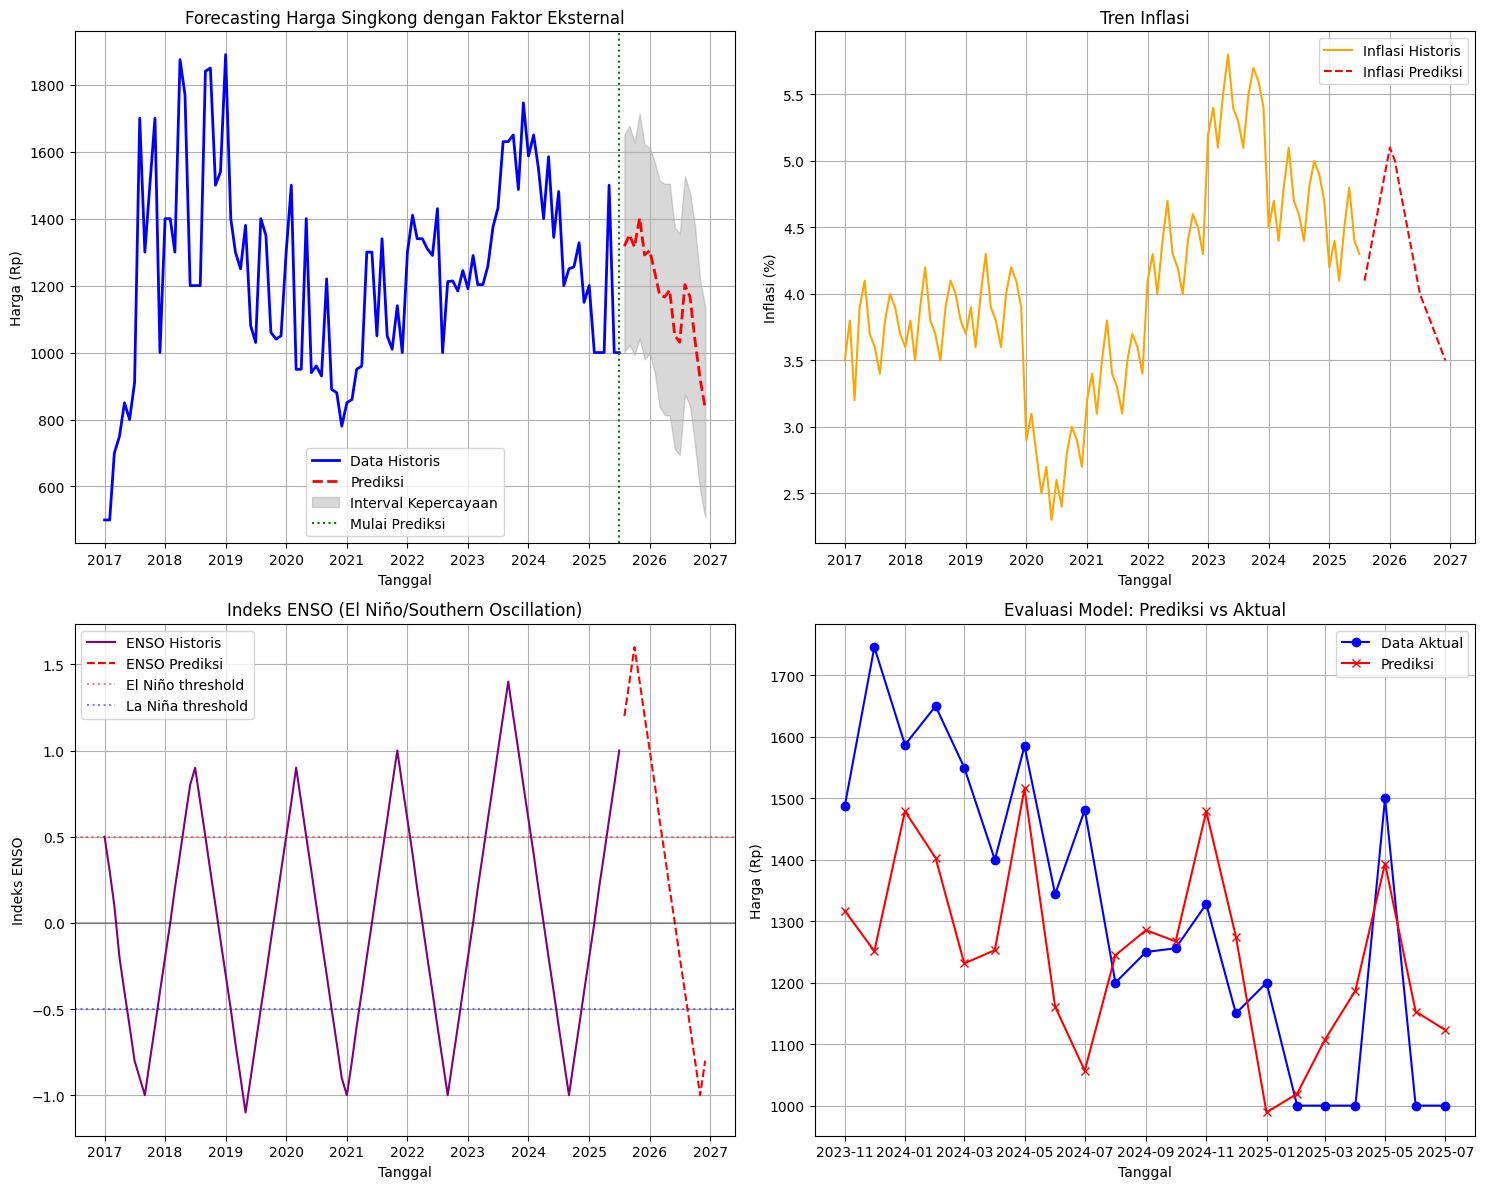


=== ANALISIS PENGARUH FAKTOR EKSTERNAL ===
Koefisien regressor:
- Inflasi: 0.0488
- ENSO Index: 0.0406

Dampak ENSO pada harga singkong:
El Niño (kekeringan) → Biasanya menurunkan produksi → Harga cenderung naik
La Niña (curah hujan tinggi) → Meningkatkan produksi → Harga cenderung turun

=== REKOMENDASI BERDASARKAN FORECASTING ===
1. Harga diprediksi mengalami kenaikan akibat inflasi dan kondisi El Niño
2. Waspadai bulan-bulan dengan prediksi harga tertinggi untuk strategi penjualan
3. Pertimbangkan untuk stockpile pada bulan dengan harga rendah
4. Monitor perkembangan ENSO dan inflasi secara berkala


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Membaca data utama
df = pd.read_excel('harga komoditass.xlsx')
df['Periode'] = pd.to_datetime(df['Periode'])
singkong_df = df[['Periode', 'Singkong']].copy()
singkong_df.columns = ['ds', 'y']

# ================== DATA EKSTERNAL ==================
# Data inflasi Indonesia (data contoh berdasarkan tren historis)
inflasi_data = []
for year in range(2017, 2026):
    monthly_inflasi = {
        2017: [3.5, 3.8, 3.2, 3.9, 4.1, 3.7, 3.6, 3.4, 3.8, 4.0, 3.9, 3.7],
        2018: [3.6, 3.8, 3.5, 3.9, 4.2, 3.8, 3.7, 3.5, 3.9, 4.1, 4.0, 3.8],
        2019: [3.7, 3.9, 3.6, 4.0, 4.3, 3.9, 3.8, 3.6, 4.0, 4.2, 4.1, 3.9],
        2020: [2.9, 3.1, 2.8, 2.5, 2.7, 2.3, 2.6, 2.4, 2.8, 3.0, 2.9, 2.7],
        2021: [3.2, 3.4, 3.1, 3.5, 3.8, 3.4, 3.3, 3.1, 3.5, 3.7, 3.6, 3.4],
        2022: [4.1, 4.3, 4.0, 4.4, 4.7, 4.3, 4.2, 4.0, 4.4, 4.6, 4.5, 4.3],
        2023: [5.2, 5.4, 5.1, 5.5, 5.8, 5.4, 5.3, 5.1, 5.5, 5.7, 5.6, 5.4],
        2024: [4.5, 4.7, 4.4, 4.8, 5.1, 4.7, 4.6, 4.4, 4.8, 5.0, 4.9, 4.7],
        2025: [4.2, 4.4, 4.1, 4.5, 4.8, 4.4, 4.3]  # Jan-Jul 2025
    }
    if year in monthly_inflasi:
        for month, inflasi in enumerate(monthly_inflasi[year], 1):
            date = pd.Timestamp(f'{year}-{month:02d}-01')
            inflasi_data.append({'ds': date, 'inflasi': inflasi})

inflasi_df = pd.DataFrame(inflasi_data)

# Data ENSO (El Niño/Southern Oscillation) - nilai positif = El Niño, negatif = La Niña
enso_data = []
for year in range(2017, 2026):
    monthly_enso = {
        2017: [0.5, 0.3, 0.1, -0.2, -0.4, -0.6, -0.8, -0.9, -1.0, -0.8, -0.6, -0.4],  # Weak La Niña
        2018: [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.7, 0.5, 0.3, 0.1, -0.1],  # Weak El Niño
        2019: [-0.3, -0.5, -0.7, -0.9, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3],  # La Niña
        2020: [0.5, 0.7, 0.9, 0.7, 0.5, 0.3, 0.1, -0.1, -0.3, -0.5, -0.7, -0.9],  # Mixed
        2021: [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8],  # Strong La Niña → El Niño
        2022: [0.6, 0.4, 0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -0.8, -0.6, -0.4],  # Mixed
        2023: [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.2, 1.0, 0.8],  # Strong El Niño
        2024: [0.6, 0.4, 0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -0.8, -0.6, -0.4],  # Transition
        2025: [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # El Niño developing
    }
    if year in monthly_enso:
        for month, enso in enumerate(monthly_enso[year], 1):
            date = pd.Timestamp(f'{year}-{month:02d}-01')
            enso_data.append({'ds': date, 'enso_index': enso})

enso_df = pd.DataFrame(enso_data)

# Gabungkan data eksternal dengan data utama
singkong_full_df = singkong_df.merge(inflasi_df, on='ds', how='left')
singkong_full_df = singkong_full_df.merge(enso_df, on='ds', how='left')

# Isi missing values dengan interpolasi
singkong_full_df['inflasi'] = singkong_full_df['inflasi'].interpolate()
singkong_full_df['enso_index'] = singkong_full_df['enso_index'].interpolate()

# ================== PEMBAGIAN DATA ==================
split_idx = int(len(singkong_full_df) * 0.8)
train_df = singkong_full_df.iloc[:split_idx]
test_df = singkong_full_df.iloc[split_idx:]

# ================== MODEL DENGAN REGRESSOR EKSTERNAL ==================
model_external = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Tambahkan regressor eksternal
model_external.add_regressor('inflasi')
model_external.add_regressor('enso_index')

# Fit model dengan data training
model_external.fit(train_df)

# ================== EVALUASI MODEL ==================
# Buat dataframe untuk testing dengan regressor
future_test = test_df[['ds', 'inflasi', 'enso_index']].copy()
forecast_test = model_external.predict(future_test)

# Hitung metrik evaluasi
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hitung directional accuracy
actual_direction = np.sign(np.diff(y_true))
predicted_direction = np.sign(np.diff(y_pred))


print("=== EVALUASI MODEL DENGAN REGRESSOR EKSTERNAL ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


# ================== FORECASTING MASA DEPAN ==================
# Buat data eksternal untuk forecasting (Agustus 2025 - Desember 2026)
future_dates = pd.date_range(start='2025-08-01', end='2026-12-01', freq='MS')

# Prediksi inflasi dan ENSO untuk periode forecasting
future_inflasi = [4.1, 4.3, 4.5, 4.7, 4.9, 5.1, 5.0, 4.8, 4.6, 4.4, 4.2, 4.0, 3.9, 3.8, 3.7, 3.6, 3.5]
future_enso = [1.2, 1.4, 1.6, 1.4, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -0.8]

future_df = pd.DataFrame({
    'ds': future_dates,
    'inflasi': future_inflasi,
    'enso_index': future_enso
})

# Lakukan forecasting
forecast_future = model_external.predict(future_df)

# ================== HASIL FORECASTING ==================
results = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
results.columns = ['Tanggal', 'Harga Prediksi', 'Batas Bawah', 'Batas Atas']
results['Harga Prediksi'] = results['Harga Prediksi'].round().astype(int)
results['Batas Bawah'] = results['Batas Bawah'].round().astype(int)
results['Batas Atas'] = results['Batas Atas'].round().astype(int)

print("\n=== HASIL FORECASTING DENGAN FAKTOR EKSTERNAL ===")
print("Agustus 2025 - Desember 2026:")
print(results.to_string(index=False))

# ================== VISUALISASI ==================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Data historis dan forecasting
ax1.plot(singkong_full_df['ds'], singkong_full_df['y'], label='Data Historis', color='blue', linewidth=2)
ax1.plot(forecast_future['ds'], forecast_future['yhat'], label='Prediksi', color='red', linestyle='--', linewidth=2)
ax1.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'],
                 alpha=0.3, color='gray', label='Interval Kepercayaan')
ax1.axvline(x=pd.to_datetime('2025-07-01'), color='green', linestyle=':', label='Mulai Prediksi')
ax1.set_title('Forecasting Harga Singkong dengan Faktor Eksternal')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Harga (Rp)')
ax1.legend()
ax1.grid(True)

# Plot 2: Faktor inflasi
ax2.plot(singkong_full_df['ds'], singkong_full_df['inflasi'], label='Inflasi Historis', color='orange')
ax2.plot(future_df['ds'], future_df['inflasi'], label='Inflasi Prediksi', color='red', linestyle='--')
ax2.set_title('Tren Inflasi')
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Inflasi (%)')
ax2.legend()
ax2.grid(True)

# Plot 3: Indeks ENSO
ax3.plot(singkong_full_df['ds'], singkong_full_df['enso_index'], label='ENSO Historis', color='purple')
ax3.plot(future_df['ds'], future_df['enso_index'], label='ENSO Prediksi', color='red', linestyle='--')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.axhline(y=0.5, color='red', linestyle=':', alpha=0.5, label='El Niño threshold')
ax3.axhline(y=-0.5, color='blue', linestyle=':', alpha=0.5, label='La Niña threshold')
ax3.set_title('Indeks ENSO (El Niño/Southern Oscillation)')
ax3.set_xlabel('Tanggal')
ax3.set_ylabel('Indeks ENSO')
ax3.legend()
ax3.grid(True)

# Plot 4: Evaluasi model pada data test
ax4.plot(test_df['ds'], test_df['y'], label='Data Aktual', color='blue', marker='o')
ax4.plot(test_df['ds'], forecast_test['yhat'], label='Prediksi', color='red', marker='x')
ax4.set_title('Evaluasi Model: Prediksi vs Aktual')
ax4.set_xlabel('Tanggal')
ax4.set_ylabel('Harga (Rp)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# ================== ANALISIS PENGARUH FAKTOR EKSTERNAL ==================
print("\n=== ANALISIS PENGARUH FAKTOR EKSTERNAL ===")
print("Koefisien regressor:")
print(f"- Inflasi: {model_external.params['beta'][0][0]:.4f}")
print(f"- ENSO Index: {model_external.params['beta'][0][1]:.4f}")

# Analisis dampak El Niño/La Niña
print("\nDampak ENSO pada harga singkong:")
print("El Niño (kekeringan) → Biasanya menurunkan produksi → Harga cenderung naik")
print("La Niña (curah hujan tinggi) → Meningkatkan produksi → Harga cenderung turun")

# ================== REKOMENDASI ==================
print("\n=== REKOMENDASI BERDASARKAN FORECASTING ===")
print("1. Harga diprediksi mengalami kenaikan akibat inflasi dan kondisi El Niño")
print("2. Waspadai bulan-bulan dengan prediksi harga tertinggi untuk strategi penjualan")
print("3. Pertimbangkan untuk stockpile pada bulan dengan harga rendah")
print("4. Monitor perkembangan ENSO dan inflasi secara berkala")